<a href="https://colab.research.google.com/github/kimbird0/deep-learning-toy/blob/main/Waldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gcsfs

In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kairess/find-waldo

100% 260M/261M [00:02<00:00, 91.9MB/s]
100% 261M/261M [00:02<00:00, 94.8MB/s]


In [6]:
!unzip -qq "/content/find-waldo.zip"

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list


ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        981           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       6451           False  
https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries                      2023-10-11 23:59:00  Featured           $60,000        510           False  
https://www.kaggle.com/competitions/bengaliai-speech                                          2023-10-17 23:59:00  Research           $53,000    

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
from skimage.transform import resize

import threading, random, os

Using TensorFlow backend.

# **Load Dataset**

In [9]:
imgs = np.load('dataset/imgs_uint8.npy').astype(np.float32) / 255.
labels = np.load('dataset/labels_uint8.npy').astype(np.float32) / 255.
waldo_sub_imgs = np.load('dataset/waldo_sub_imgs_uint8.npy', allow_pickle=True) / 255.
waldo_sub_labels = np.load('dataset/waldo_sub_labels_uint8.npy', allow_pickle=True) / 255.


print(imgs.shape, labels.shape)
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)

(18, 1760, 2800, 3) (18, 1760, 2800)
(18,) (18,)


# **Data Generator**

In [10]:
PANNEL_SIZE = 224

class BatchIndices(object):
    """
    Generates batches of shuffled indices.
    # Arguments
        n: number of indices
        bs: batch size
        shuffle: whether to shuffle indices, default False

    """
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n)
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

class segm_generator(object):
    """
    Generates batches of sub-images.
    # Arguments
        x: array of inputs
        y: array of targets
        bs: batch size
        out_sz: dimension of sub-image
        train: If true, will shuffle/randomize sub-images
        waldo: If true, allow sub-images to contain targets.
    """
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci)
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (random.random()>0.5):
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None

        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)

def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):
    """
    Mixes generator output. The second generator is set to skip images that contain any positive targets.
    # Arguments
        x1, y1: input/targets for waldo sub-images
        x2, y2: input/targets for whole images
        tot_bs: total batch size
        prop: proportion of total batch size consisting of first generator output
    """
    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

# **Preview Sample Pannel Images**

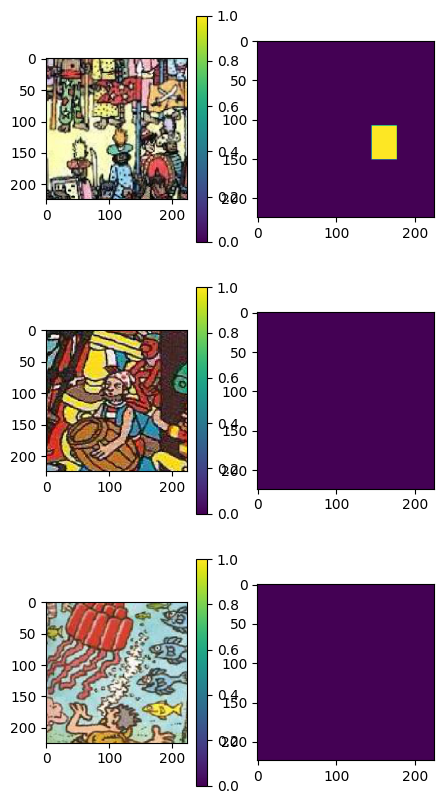

In [11]:
# waldo : not_waldo = 1 : 2 (0.34)
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

# **Plot Y-Data Distribution**

88666846 37154


<ipython-input-12-3a8946803d72>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2502: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.hist(a, bins, orientation=orientation,


<Axes: >

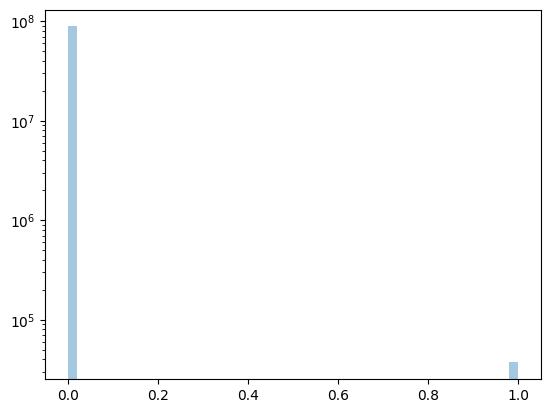

In [12]:
freq0 = np.sum(labels==0)
freq1 = np.sum(labels==1)

print(freq0, freq1)

sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})

# **Make Class Weights (0 and 1)**

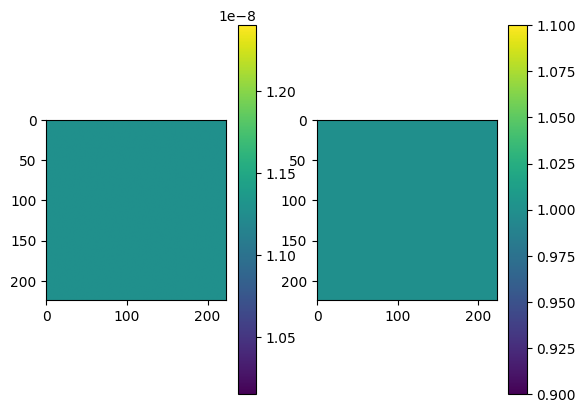

In [13]:
sample_weights = np.zeros((6, PANNEL_SIZE * PANNEL_SIZE, 2))

sample_weights[:,:,0] = 1. / freq0
sample_weights[:,:,1] = 1.

plt.subplot(1,2,1)
plt.imshow(sample_weights[0,:,0].reshape((224, 224)))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sample_weights[0,:,1].reshape((224, 224)))
plt.colorbar()